In [1]:
!pip install yfinance tensorflow scikit-learn matplotlib pandas numpy


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
# Stock symbol (change if required)
TICKER = "AAPL"   # Example: "TCS.NS", "RELIANCE.NS"
START = "2015-01-01"
END = "2024-12-31"

# Download data
df = yf.download(TICKER, start=START, end=END)

df.head()


/tmp/ipython-input-2955036090.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237549,24.705318,23.798599,24.694233,212818400
2015-01-05,23.554743,24.086803,23.368523,24.006994,257142000
2015-01-06,23.556961,23.816340,23.195602,23.619034,263188400
2015-01-07,23.887281,23.987042,23.654504,23.765350,160423600
2015-01-08,24.805073,24.862713,24.097876,24.215374,237458000


In [4]:
# Moving Average
df['MA50'] = df['Close'].rolling(window=50).mean()

# RSI calculation
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

df = df.dropna()
df.head()


Price,Close,High,Low,Open,Volume,MA50,RSI
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,
2015-03-16,27.809702,27.809702,27.346765,27.571556,143497200,26.586999,32.710822
2015-03-17,28.274857,28.337175,27.965489,28.021131,204092400,26.667745,45.533411
2015-03-18,28.593134,28.746705,28.125744,28.265961,261083600,26.768513,44.971654
2015-03-19,28.377245,28.766737,28.354989,28.655453,183238000,26.864919,47.391319
2015-03-20,28.021135,28.577550,27.856437,28.544167,274780400,26.947596,41.765560


In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['Close']])

LOOK_BACK = 60

X, y = [], []

for i in range(LOOK_BACK, len(scaled_data)):
    X.append(scaled_data[i-LOOK_BACK:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape for LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [6]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
early_stop = EarlyStopping(monitor='loss', patience=5)

model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0207
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0012
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0012
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 9.8553e-04
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 8.4655e-04
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 9.8761e-04
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 9.0727e-04
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 7.9645e-04
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 8.8952e-04
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0011
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 6.2240e-04
Epoch 12/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 6.2343e-04
Epoch 13/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 9.1764e-04
Epoch 14/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 6.9039e-04
Epoch 15/20
61/61 ━━━━━━━━━━━━━

In [8]:
predicted = model.predict(X_test)

predicted_prices = scaler.inverse_transform(predicted.reshape(-1,1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1,1))


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


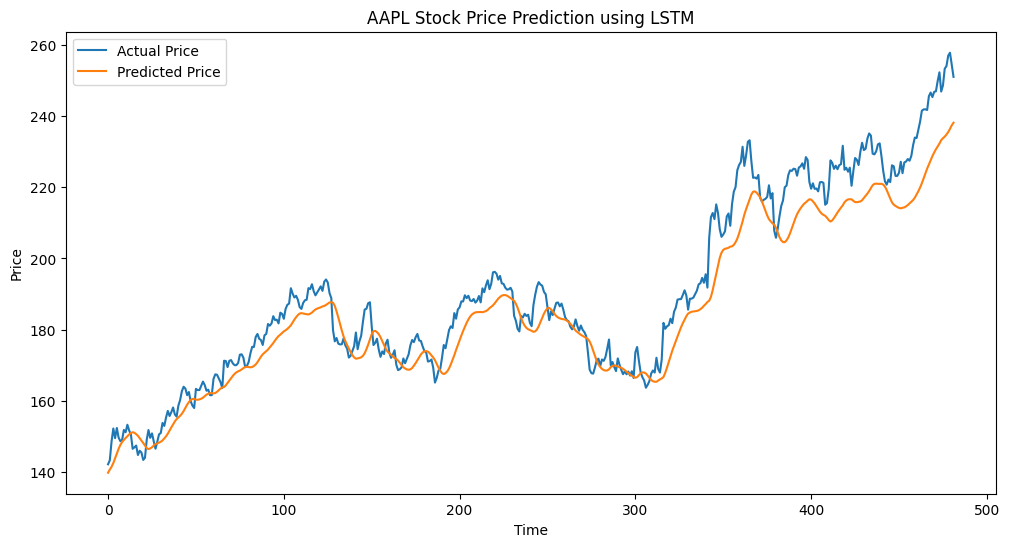

In [9]:
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.title(f"{TICKER} Stock Price Prediction using LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


In [11]:
model.save("lstm_stock_model.keras")

print("Model saved successfully!")


Model saved successfully!
